Introduction
-----------------

Description on Kaggle: You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

In [1]:
from IPython.display import HTML
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load helper functions. Cannot figure out how to import these like normal.
%run ../src/helpers/utilities.py

# Needed for inline plots.
%matplotlib inline

# Default matplotlib options.
plt.rcParams['figure.figsize']=(10, 7)

In [2]:
# Load the training/test data.
train, test = pd.read_csv("../data/raw/sales_train.csv"), pd.read_csv("../data/raw/test.csv")

# Load the external data.
files = [
    "shops.csv",
    "items.csv",
    "item_categories.csv"
]

shops, items, item_categories = [pd.read_csv("../data/raw/" + file) for file in files]

In [3]:
display(HTML("<h3>Columns</h3>"))
display(html_list_columns("Train: ", train.keys()))
display(html_list_columns("Test: ", test.keys()))
display(html_list_columns("Items: ", items.keys()))
display(html_list_columns("Item Categories: ", item_categories.keys()))
display(html_list_columns("Shops: ", shops.keys()))

In [4]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
# General Description
for key, value in train.item_price.describe().items():
    print(key + ": ", "{:.2f}".format(value))

count:  2935849.00
mean:  890.85
std:  1729.80
min:  -1.00
25%:  249.00
50%:  399.00
75%:  999.00
max:  307980.00


It's odd that there's a minimum item_price of -1. How many are there?

In [6]:
(train.item_price <= 0).sum()

1

### Setup

Dates are in a non-standard format, so we'll clean those up first.

In [7]:
# Use python's native date format. Odd that this takes a few seconds to complete.
train["date"] = train.date.apply(lambda x: datetime.datetime.strptime(x, "%d.%m.%Y"))
train["year"] = train.date.apply(lambda x: x.year)
train["month"] = train.date.apply(lambda x: x.month)

Now join the items, shops, and item_categories to the training data.

In [8]:
# Does the training data maintain it's original length.
original_len = len(train)

# Merge train and items.
train = pd.merge(train, items, how="left", on="item_id")

# Merge train and shops
train = pd.merge(train, shops, how="left", on="shop_id")

# Merge train and item_categories
train = pd.merge(train, item_categories, how="left", on="item_category_id")

# Excepcted difference is 0.
len(train) - original_len

0

In [9]:
# Create an HTML list of new columns.
html_list_columns("Columns in train ", train.keys())

In [10]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,item_name,item_category_id,shop_name,item_category_name
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


With a minimum item price of -1, how many are below the expected minimum of 0?

### Setting up the Target

Our goal it to predict how many products will be sold in the next month. We may need to aggregate first before training out models, but we could potentially just train a model using the daily counts and aggregate when we're done.

In [11]:
# What is the min and maximum dates?
min(train.date), max(train.date)

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-10-31 00:00:00'))

We want to predict the total number of items sold during the next month. For this dataset, that would be November 2015.

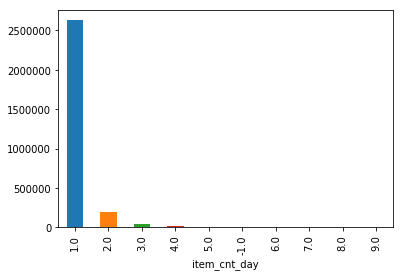

In [12]:
# Top Daily Counts.
train.item_cnt_day \
    .groupby(train.item_cnt_day) \
    .count() \
    .sort_values(ascending=False) \
    .head(10) \
    .plot(kind="bar")

The traning data is broken out by item and shop, so this tells us the vast majority of shops sell one kind of item per day. Now we'll calculate the counts per month.

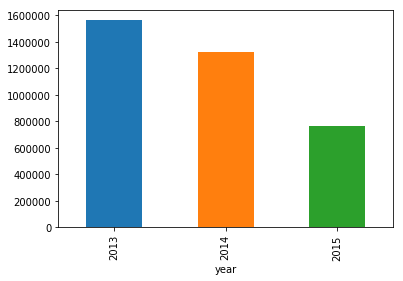

In [13]:
# Top Daily Counts.
train.item_cnt_day \
    .groupby(train.year) \
    .sum() \
    .sort_values(ascending=False) \
    .plot(kind="bar")

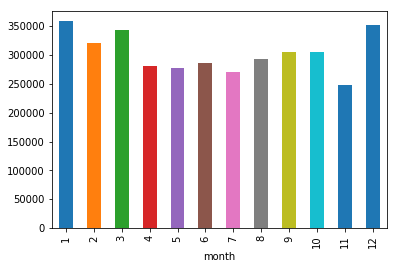

In [14]:
# Top Daily Counts.
train.item_cnt_day \
    .groupby(train.month) \
    .sum() \
    .plot(kind="bar")